In [1]:
from torchvision.models import alexnet, AlexNet_Weights
from PIL import Image
import cv2
import numpy as np

In [2]:
weights = AlexNet_Weights.DEFAULT
transforms = weights.transforms()

In [3]:
model = alexnet(weights=weights)

In [4]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach().numpy().squeeze()
    return hook

In [5]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [71]:
from lucent.optvis import render, param, transform, objectives
from torch.nn import functional as F
import lucent
from torchvision import models
from lucent.modelzoo.util import get_model_layers


In [62]:
model = models.alexnet(pretrained=True).eval()

/Users/jrothadmin/opt/miniconda3/envs/CNNvis/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jrothadmin/opt/miniconda3/envs/CNNvis/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: module 'lucent' has no attribute 'modelzoo'

In [72]:
get_model_layers(model)

['features',
 'features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

In [73]:
obj = objectives.channel(f'features_0', 0)
img_param = lambda: param.image(224, fft=True, decorrelate=True)
img = render.render_vis(model, obj, param_f=img_param, transforms=transform.standard_transforms, show_image=False)[-1][0]

100%|██████████| 512/512 [00:30<00:00, 16.70it/s]


In [75]:
from PIL import Image

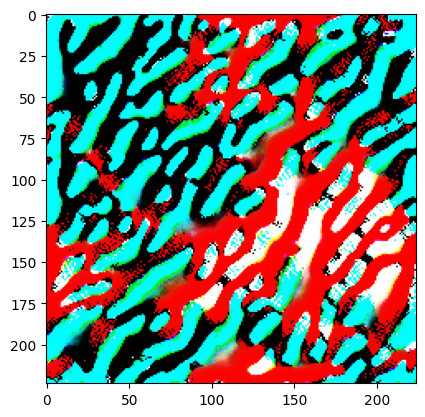

In [82]:
plt.imshow(img)

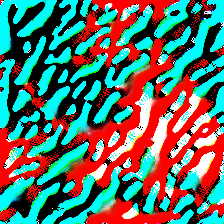

In [89]:
Image.fromarray((img * 255).astype(np.uint8))

In [5]:
cnn_feature_keys = [0, 3, 6, 8, 10]
for key in cnn_feature_keys:
    model.features[key].register_forward_hook(get_activation(f'conv_{key}'))

In [17]:
clf_feature_keys = [1, 4, 6]
for key in clf_feature_keys:
    model.classifier[key].register_forward_hook(get_activation(f'fc_{key}'))

In [109]:
filter = model.features[0].weight.data[neuron_idx].cpu().numpy()
imzg = Image.fromarray(scale(filter  255).astype(np.uint8))
filter_path = os.path.join(layer_path, f"filter_{filter_idx}.npy")
img.save(filter_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


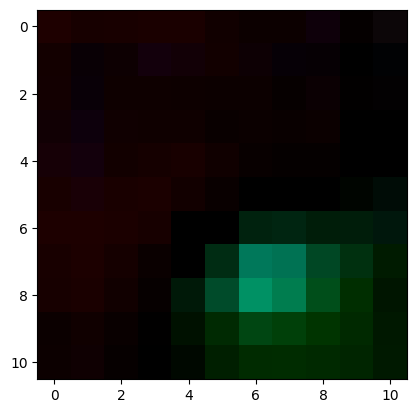

In [116]:
plt.imshow(filter)

In [120]:
img = Image.fromarray(scale(filter, max=255).astype(np.uint8))
img.thumbnail((256, 256))

/var/folders/m8/zwh1z64j29dcvf8xky0h7qdc0000gq/T/ipykernel_33263/3515821498.py:1: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img.resize((256, 256), Image.NEAREST)


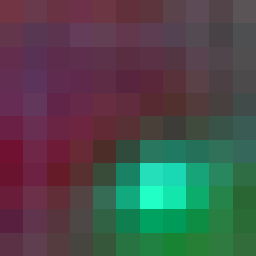

In [123]:
img.resize((256, 256), Image.NEAREST)

In [ ]:
plt.imshow

In [6]:
def scale(array, min=0, max=1):
    return (array - array.min()) / (array.max() - array.min()) * (max - min) + min

In [18]:
n_cols = 9
spacing_px = 20

In [42]:
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    rval, frame = vc.read()

    img = transforms(Image.fromarray(frame)).unsqueeze(0)
    _ = model(img)

    fmap_imgs = []
    for i, key in enumerate(activation.keys()):
        fmaps = scale(activation[key])
        fmaps = fmaps ** 0.5
        
        n_fmaps = fmaps.shape[0]
        fmap_size = fmaps.shape[1] if len(fmaps.shape) == 3 else 1
        n_rows = n_fmaps // n_cols + 1

        stitched_activations = np.zeros((fmap_size * n_rows, fmap_size * n_cols))
    
        for i, fmap in enumerate(fmaps):
            r = i // n_cols
            c = i % n_cols
            stitched_activations[r * fmap_size:(r + 1) * fmap_size, c * fmap_size:(c + 1) * fmap_size] = fmap

        fmap_imgs.append(stitched_activations)
    
    max_fmap_height = max([fmap_img.shape[0] for fmap_img in fmap_imgs]) + frame.shape[0] // 20
    total_fmap_width = sum([fmap_img.shape[1] for fmap_img in fmap_imgs]) + len(fmap_imgs) * spacing_px

    stitched_fmaps = np.zeros((max_fmap_height, total_fmap_width))
    c = 0
    for fmap_img in fmap_imgs:
        # leave 10 px between each fmap
        stitched_fmaps[:fmap_img.shape[0], c:c + fmap_img.shape[1]] = fmap_img
        c += fmap_img.shape[1] + spacing_px

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # resize to same ratio, but 10 times smaller
    frame = cv2.resize(frame, (0, 0), fx=0.2, fy=0.2)

    frame_height, frame_width = frame.shape
    # put frame to lower left corner of stitched fmaps
    stitched_fmaps[-frame_height:, :frame_width] = scale(frame)
    
    cv2.imshow("preview", stitched_fmaps)
    
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break

vc.release()
cv2.destroyWindow("preview")


/var/folders/m8/zwh1z64j29dcvf8xky0h7qdc0000gq/T/ipykernel_29493/2379696108.py:2: RuntimeWarning: invalid value encountered in divide
  return (array - array.min()) / (array.max() - array.min()) * (max - min) + min


: 

In [24]:
frame.shape

(1080, 1920, 3)

In [9]:
stitched_fmaps.shape

(675, 1068)

In [ ]:
stitched_fmaps

In [1]:
from src.cnn_vis.camera import ThreadedVideoCapture
from src.cnn_vis.extractor import AlexNetExtractor
import matplotlib.pyplot as plt
import cv2

In [2]:
vc = ThreadedVideoCapture().start()

2024-04-29 15:57:41.874 python3.8[90041:42914288] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


In [3]:
ret, frame = vc.read()

In [1]:
import io
from torchvision.models import alexnet, AlexNet_Weights
from PIL import Image, ImageTk
import PySimpleGUI as sg
import cv2
import numpy as np
import matplotlib.pyplot as plt

from src.cnn_vis.extractor import AlexNetExtractor
from src.cnn_vis.camera import ThreadedVideoCapture

In [2]:
def frame_to_imagetk(frame, first=True):
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mode = "L" if len(frame.shape) == 2 else "RGB"
    frame_img = Image.fromarray(frame, mode=mode)
    frame_img.thumbnail((640, 480))

    if first:  # tkinter is inactive the first time
        bio = io.BytesIO()
        frame_img.save(bio, format="PNG")
        del frame_img
        return bio.getvalue()

    frame_tk = ImageTk.PhotoImage(frame_img)
    return frame_tk

In [3]:
extractor = AlexNetExtractor()
vc = ThreadedVideoCapture().start()

2024-05-08 16:20:05.519 python3.8[33263:88470264] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


In [42]:
ret, frame = vc.read()

In [43]:
feats, labels, probs = extractor.run_inference(
    Image.fromarray(frame),
)

In [44]:
def scale(array, min=0, max=1):
    return (array - array.min()) / (array.max() - array.min()) * (max - min) + min

In [45]:
from io import BytesIO

In [56]:
feats['conv_0'][1]

3.3319995

In [57]:
img = Image.fromarray(scale(feats['conv_0'][1], max=255).astype(np.uint8), 'L')
# buffer = BytesIO()
# img.save(buffer, format="JPEG")

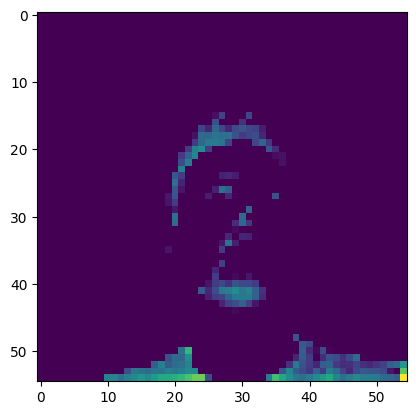

In [47]:
plt.imshow(feats['conv_0'][1])

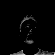

In [58]:
img

In [9]:
def stitch_feat_maps_to_rect(feat_maps, gap=10, gap_color=10):
    n_fmaps = feat_maps.shape[0]
    n_cols = 12
    n_rows = n_fmaps // n_cols + (1 if n_fmaps % n_cols != 0 else 0)
    fmap_size = feat_maps.shape[1]
    # Adjust the size of the stitched_fmaps to accommodate the gaps
    stitched_fmaps = np.zeros((fmap_size * n_rows + gap * (n_rows - 1),
                               fmap_size * n_cols + gap * (n_cols - 1))) + gap_color

    for i, fmap in enumerate(feat_maps):
        r = i // n_cols
        c = i % n_cols
        row_start = r * (fmap_size + gap)
        col_start = c * (fmap_size + gap)
        stitched_fmaps[row_start:row_start + fmap_size, col_start:col_start + fmap_size] = fmap
    
    return stitched_fmaps

In [10]:
stitched_fmaps = stitch_feat_maps_to_rect(feats['conv_0'])

In [11]:
stitched_fmaps = scale(stitched_fmaps, max=255).astype(np.uint8)

In [14]:
stitched_fmaps.shape

(380, 770)

In [12]:
import matplotlib.pyplot as plt

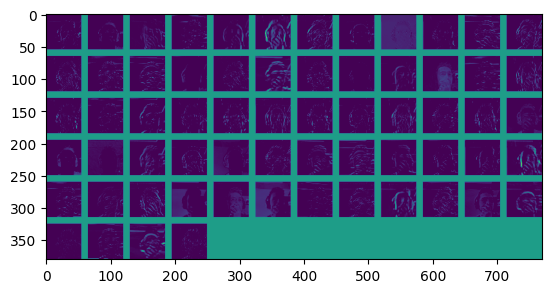

In [13]:
plt.imshow(stitched_fmaps)

In [20]:
stitched_fmaps

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   1,   0,   0],
       ...,
       [  0,   0,   0, ..., 146, 146, 146],
       [  0,   0,   0, ..., 146, 146, 146],
       [  0,   0,   0, ..., 146, 146, 146]], dtype=uint8)

In [23]:
layout = [
    [
        sg.Image(
            key="frame",
            data=frame_to_imagetk(np.zeros((224, 224, 3), dtype=np.uint8)),
        )
    ]
]
window = sg.Window("CNN Visualizer", layout, finalize=True)


In [24]:
frame_tk = ImageTk.PhotoImage(Image.fromarray(stitched_fmaps, mode="L").resize((400, 400), Image.NEAREST))


/var/folders/m8/zwh1z64j29dcvf8xky0h7qdc0000gq/T/ipykernel_89094/3124094717.py:1: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  frame_tk = ImageTk.PhotoImage(Image.fromarray(stitched_fmaps, mode="L").resize((400, 400), Image.NEAREST))


In [26]:
window["frame"].update(data=frame_tk)

In [2]:
frame_img

NameError: name 'frame_img' is not defined

frame_img = Image.fromarray(frame, mode=mode)

In [2]:
from gpt2_cnnvis.backend.scripts.precompute_deepdream_acts import AlexNetFeatureVisualizer

In [3]:
vis = AlexNetFeatureVisualizer()

/Users/jrothadmin/opt/miniconda3/envs/CNNvis/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jrothadmin/opt/miniconda3/envs/CNNvis/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
from lucent.optvis import objectives, param, render, transform
from PIL import Image

In [24]:
vis.fc_activations['fc_6'].shape

torch.Size([1, 1000])

In [12]:
vis.model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [14]:
obj = objectives.channel(f"classifier_{6}", 0)
img_param = lambda: param.image(224, fft=True, decorrelate=True)
img = render.render_vis(
    vis.model,
    obj,
    param_f=img_param,
    transforms=transform.standard_transforms,
    show_image=False,
)[-1][0]

100%|██████████| 512/512 [01:09<00:00,  7.35it/s]


In [15]:
import matplotlib.pyplot as plt
import numpy as np

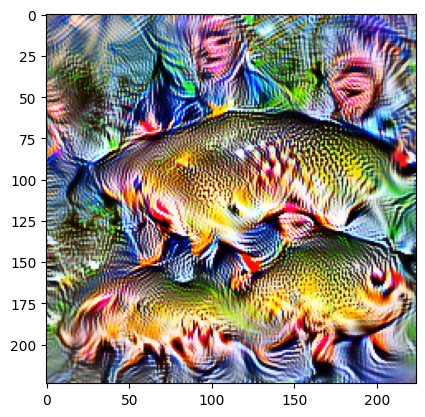

In [16]:
plt.imshow(img)

In [15]:
up_img = Image.fromarray((img * 255).astype(np.uint8))

In [20]:
filter = (
    vis.model.features[3]
    .weight.data[0].cpu()
    .numpy()
)

In [21]:
filter.shape

(64, 5, 5)